In [2]:
from for_importing import X_cleaned
from binning_to_import import y_bins
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import recall_score


In [3]:
y=y_bins['cluster']
xtr,xts,ytr,yts=train_test_split(X_cleaned,y,test_size=0.2,random_state=22)

The accuracy of the SVM is 87.72%


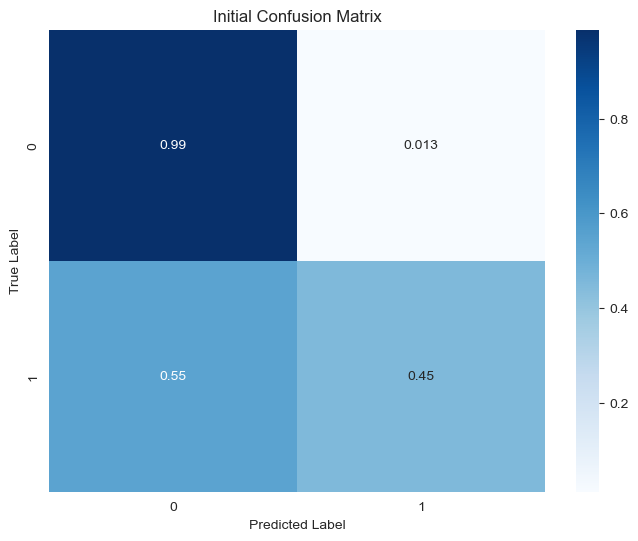

In [4]:
svc = svm.SVC( kernel='rbf')

x2tr,x2ts=xtr[['racePctWhite','PctKids2Par']],xts[['racePctWhite','PctKids2Par']]

svc.fit(x2tr, ytr)
y_pred = svc.predict(x2ts)
print(f'The accuracy of the SVM is {round(svc.score(x2ts, yts) * 100, 2)}%')

y_true = yts

C_norm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(C_norm, annot=True, cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Initial Confusion Matrix")
plt.show()




Here, we see the effects of the class imbalance. The model predicts the low crime class with 99% accuracy, but only predicts the high crime class with 45% accuracy. This will be addressed by class balancing. But first, I want to optimize C and gamma.

In [5]:
C_test =np.logspace(-1,2,30)
gam_test =np.logspace(-4,-1,30) 

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

#
for i, C in enumerate(C_test):
    for j, gam in enumerate(gam_test):
          svc = svm.SVC(C=C,gamma=gam)
          svc.fit(x2tr,ytr)
          acc[i,j] = svc.score(x2ts,yts)

max_index = np.unravel_index(np.argmax(acc), acc.shape)

print(f'When C = {round(C_test[max_index[0]],3)} and gamma = {round(gam_test[max_index[1]],3)}, we get a maximum accuracy of {round(np.max(acc)*100,2)}%')

When C = 4.52 and gamma = 0.079, we get a maximum accuracy of 87.47%


In [6]:
best_C=C_test[max_index[0]]
best_gamma=C_test[max_index[0]]
final_svc=svm.SVC(C=best_C,gamma=best_gamma,kernel='rbf')
svc.fit(x2tr, ytr)
y_pred = svc.predict(x2ts)
print(f'Our SVM model with C={round(best_C,3)}, gamma={round(best_gamma,3)} is {round(np.max(acc)*100,2)}% accurate')


Our SVM model with C=4.52, gamma=4.52 is 87.47% accurate


In [7]:

weights=np.arange(1,10.5,0.5)
accuracies=[]
sensitivities=[]
specificities=[]

for weight in weights:
    svc = svm.SVC(C=best_C,gamma=best_gamma,kernel='rbf',class_weight={'0':1,'1':weight})
    svc.fit(x2tr,ytr)
    y_pred=svc.predict(x2ts)
    accuracies.append(svc.score(x2ts,yts))
    sensitivity = recall_score(yts, y_pred, pos_label='1')
    sensitivities.append(sensitivity)
    
    # calculate specificity (TN / (TN + FP))
    tn, fp, fn, tp = confusion_matrix(yts, y_pred).ravel()
    specificity = tn / (tn + fp)
    specificities.append(specificity)


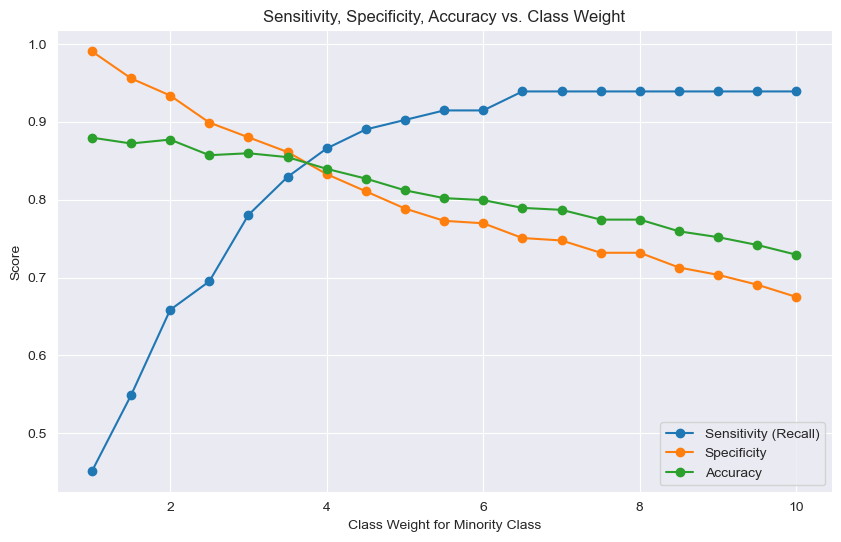

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(weights, sensitivities, label='Sensitivity (Recall)', marker='o')
plt.plot(weights, specificities, label='Specificity', marker='o')
plt.plot(weights, accuracies, label='Accuracy', marker='o')
plt.xlabel('Class Weight for Minority Class')
plt.ylabel('Score')
plt.title('Sensitivity, Specificity, Accuracy vs. Class Weight')
plt.legend()
plt.grid(True)
plt.show()

I want to prioritize minimizing false negatives (without creating too many false positives). It would be more damaging if my model predicted that a community was safe when it was dangerous, than predicting a dangerous neighborhood when it was safe. So, I am going to value specificity higher than sensitivity. Thus, I am choosing a minority class weight of 4.

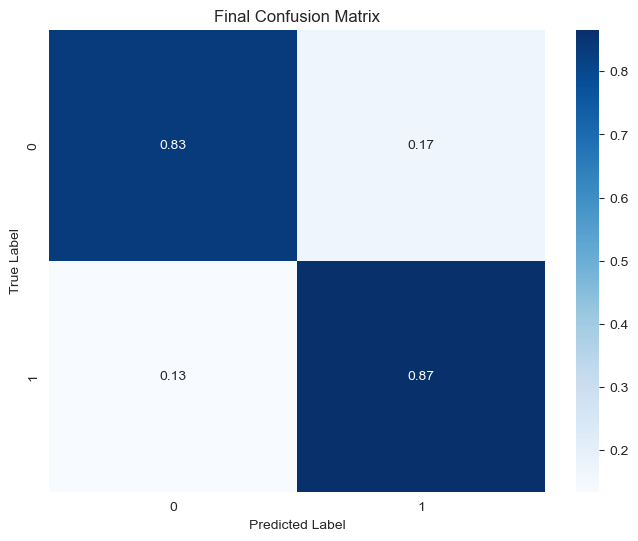

In [10]:
svc = svm.SVC(C=best_C,gamma=best_gamma,kernel='rbf',class_weight={'0':1,'1':4})
svc.fit(x2tr,ytr)
y_pred = svc.predict(x2ts)

C_norm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(C_norm, annot=True, cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Confusion Matrix")
plt.show()